In [2]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
import os

import matplotlib.pyplot as plt
import cmocean
import numpy as np
import xarray as xr
import emsarray
from emsarray import plot, transect
import dask as da
import geopandas as gpd
import cartopy.crs as ccrs
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import emsarray as emr
from shapely.geometry import Point, Polygon, box, shape
from alphashape import alphashape
from tqdm.notebook import tqdm_notebook
import csv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from datetime import datetime, timedelta
import glob
import PyCO2SYS as pyco2
from IPython.display import display, HTML
import great_circle_calculator.great_circle_calculator as gcc
import shapely
from matplotlib.colorbar import Colorbar
from scipy.interpolate import make_interp_spline

%run /g/data/ih54/ha9300/oae/Notebooks/Model_Functions.ipynb

/jobfs/127238197.gadi-pbs/ipykernel_2644380/1652164674.py:29: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as gsw


In [ ]:
cluster = start_cluser(cores=48,hours=1,mins=35)
cluster.scale(jobs=1)
client = Client(cluster)
port = client.scheduler_info()['services']['dashboard']
cliet

In [3]:
seasons = ['Summer','Winter']

In [15]:
input_file,ctrls,datasets = {},{},{}

for season in seasons:

    datasets[season] = read_shoc_nc(f'/g/data/ih54/ha9300/oae/WB_{season}/Scenarios/low_rate_time/Full_exp/Full_exp_*.nc',ems=True)
    ctrls[season] = read_shoc_nc(f'/g/data/ih54/ha9300/oae/WB_{season}/Control/control*.nc',ems=True)
    input_file[season] = read_shoc_nc(f'/g/data/ih54/ha9300/oae/WB_{season}/inputs/in_depth_t.nc',ems=True)

In [16]:
anoms = {}

for season in seasons:
    anoms[season] = datasets[season]-ctrls[season]

lats = ctrls['Summer'].latitude.values
lons = ctrls['Summer'].longitude.values

In [3]:
tas_map = {'coast' : gpd.read_file(r'/g/data/ih54/ha9300/oae/tasmania/csttascd_r.shp'),
           'roads' : gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/CWY_122022/CWY_122022.shp'),
           'power_line': gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/Electricity_Transmission_Lines/Electricity_Transmission_Lines.shp'),
           'power_station': gpd.read_file(r'/g/data/ih54/ha9300/oae/Map_Data/Major_Power_Stations/Major_Power_Stations.shp'),
          }

tas_map['coast'] = tas_map['coast'][tas_map['coast']['FEAT_CODE'] != "sea"]
tas_map['power_station'] = tas_map['power_station'][tas_map['power_station']['owner'] == "Hydro-Electric Corporation (Tasmania)"]

for key in tas_map.keys():
    
    tas_map[key] = tas_map[key].to_crs('epsg:4326')

In [8]:
masked_anoms,depth_integrated_dic = {},{}

cell = 1

if cell == 0:
    
    for season in seasons:
    
        masked_anoms[season] = shoc_ssh_mask(anoms[season],input_file[season],'DIC')
    
        vol = shoc_volume(input_file[season])      
    
        ds = vol * masked_anoms[season]
    
        depth_integrated_dic[season] = ds.DIC.sum(dim='k').values
    
        array_to_save = depth_integrated_dic[season].reshape(depth_integrated_dic[season].shape[0],-1)
    
        with open(f'integrated_DIC_{season}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(array_to_save)

else:

    for season in seasons:

        ds = np.loadtxt(f'integrated_DIC_{season}_mean.csv',delimiter=',')

        depth_integrated_dic[season] = ds.reshape((93,38))

In [21]:
def linear_interpolate(original_list, target_length):
    original_indices = np.arange(len(original_list))
    target_indices = np.linspace(0, len(original_list) - 1, target_length)
    interpolated_values = np.interp(target_indices, original_indices, original_list)

    interpolated_values = np.round(interpolated_values).astype(int)
    return interpolated_values

list1 = [0, 12, 29, 30, 24]
list2 = [40, 45, 63, 70, 92]

# Interpolate to get lists of length 30
padded_list1 = linear_interpolate(list1, 30)
padded_list2 = linear_interpolate(list2, 30)

# Convert to lists if needed
padded_list1 = padded_list1.tolist()
padded_list2 = padded_list2.tolist()

points = [[x,y] for (x,y) in zip(padded_list2,padded_list1)]

ll = []

for p in points:

    ll.append([ctrls['Summer'].longitude[p[0],p[1]].values,ctrls['Summer'].latitude[p[0],p[1]].values])

ll = [[float(item[0]), float(item[1])] for item in ll]

line = shapely.LineString(ll)

dic_section,exp_section,ctrl_section = {},{},{}
density_section = {}

for season in seasons:

    ctrl_dic = ctrls[season].ems.select_variables(['botz','DIC'])
    exp_dic = datasets[season].ems.select_variables(['botz','DIC'])
    data_dens = ctrls[season].ems.select_variables(['botz','dens_0'])

    ctrl_section[season] = transect.Transect(ctrl_dic,line).prepare_data_array_for_transect(ctrl_dic.DIC)
    exp_section[season] = transect.Transect(exp_dic,line).prepare_data_array_for_transect(exp_dic.DIC)
    
    density_section[season] = transect.Transect(data_dens,line).prepare_data_array_for_transect(data_dens.dens_0)

    dic_section[season] = exp_section[season]-ctrl_section[season]

dist_short = []

for i in range(len(line.coords) - 1):
    dist_short.append(gcc.distance_between_points(line.coords[i], line.coords[i + 1]))

dist = np.linspace(0,np.cumsum(dist_short)[-1],len(density_section['Summer'].index))
depth = ctrls['Summer'].zc.values

dic_int = {}

for season in seasons:

    dic_int[season] = []

    for j,i in zip(padded_list2,padded_list1):

        dic_int[season].append(np.mean(depth_integrated_dic[season][:,j,i],axis=0)/1000)
    
dist_for_plot = np.linspace(0,np.cumsum(dist_short)[-1],len(dic_int['Summer']) )     

Text(60.472222222222214, 0.5, 'Depth-Integrated $\\Delta$DIC (g)')

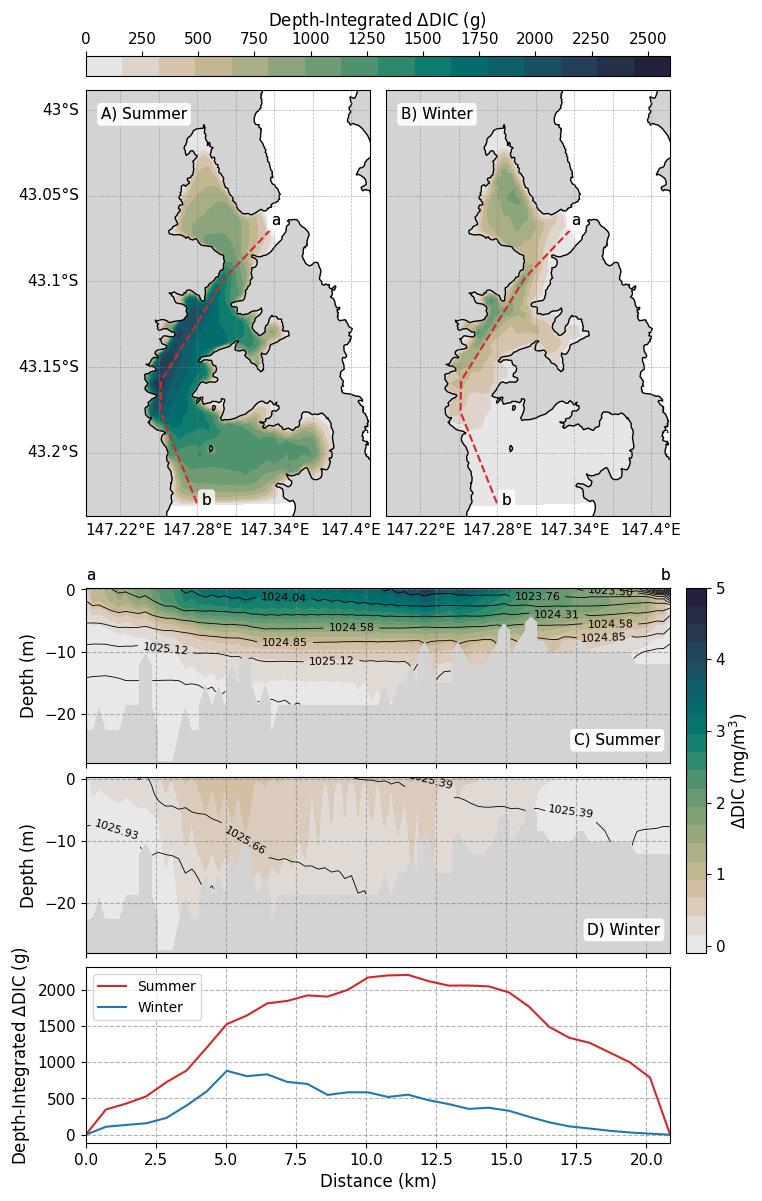

In [22]:
fig = plt.figure(figsize=(8,15),constrained_layout=False)

gs = fig.add_gridspec(4,3,wspace=0.08,hspace=0.05,height_ratios=[1,0.3,0.3,0.3],width_ratios=[1,1,0.07])#

axes = {'ax_0' : fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree()),
        'ax_1' : fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree()),
        'ax_2' : fig.add_subplot(gs[1,0:2]),
        'ax_3' : fig.add_subplot(gs[2,0:2]),
        'ax_4' : fig.add_subplot(gs[3,0:2]),
        'cbax' : fig.add_subplot(gs[1:3,2])
        }

colors = ['tab:red','tab:blue']

input_ts = {}
s_idx = {}

list1 = [0, 12, 29, 30, 24]
list2 = [40, 45, 63, 70, 92]

line_lat = [] 
line_lon = []

for i in range(5):
    line_lat.append(lats[list2[i],list1[i]])
    line_lon.append(lons[list2[i],list1[i]])

for i,season in enumerate(seasons):

    input_ts[season] = read_in_ts(f'/g/data/ih54/ha9300/oae/WB_{season}/Scenarios/low_rate_time/Full_exp/Full_exp_pulse.ts')['alk']
    s_idx[season] = np.where(input_ts[season] > 0)[0][0]

    axes[f'ax_{i}'].set_extent(extent(ctrls[season]))

    dic_plt = axes[f'ax_{i}'].contourf(lons,lats,depth_integrated_dic[season],cmap=cmocean.cm.rain,levels=np.linspace(0,2600,17))
    axes[f'ax_{i}'].plot(line_lon,line_lat,color='tab:red',linestyle='--')
    coast = tas_map['coast'].plot(ax=axes[f'ax_{i}'],color='lightgrey',edgecolor='k',zorder=2)
    
    gl = axes[f'ax_{i}'].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.5, color='grey', 
                      alpha=0.6, linestyle='--',zorder=4)
    gl.xlabel_style = {'fontsize': 11}
    gl.ylabel_style = {'fontsize': 11}

    if i == 0:
        gl.top_labels=False
        gl.right_labels=False
        gl.rotate_labels=False
    else:
        gl.top_labels=False
        gl.right_labels=False
        gl.left_labels=False
        gl.rotate_labels=False
    

    if season == 'Summer':
        b = 'ax_2'
    elif season == 'Winter':
        b = 'ax_3'
    
    log_levels = np.linspace(-0.1,5,21)
    
    cols = axes[b].contourf(dist/1000,depth,dic_section[season].isel(time=slice(s_idx[season],2233)).mean(dim='time'),
                            cmap=cmocean.cm.rain,levels=log_levels)
    
    dens = axes[b].contour(dist/1000,depth,density_section[season].isel(time=slice(s_idx[season],2233)).mean(dim='time'),
                           colors='black',linewidths=0.6,levels=np.round(np.linspace(1021.0649,1026.196,20),3))

    axes[b].clabel(dens, inline=True, fontsize=8,fmt="%.2f")
    
    axes[b].set_ylim(-28,0.3)
    axes[b].set_facecolor('lightgrey')
    axes[b].grid(color='grey',linestyle = '--',alpha=0.6)
    axes[b].set_ylabel('Depth (m)')

    map_panels = ['A) Summer','B) Winter']
    for e,x in enumerate(['ax_0','ax_1']):
        axes[x].text(147.205,-43.005,map_panels[e],fontsize=11,
                                  bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=6)

        axes[x].text(line_lon[0],line_lat[0]+0.003,'a',fontsize=11,
                                  bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'},zorder=6)

        axes[x].text(line_lon[-1]+0.003,line_lat[-1],'b',fontsize=11,
                                  bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.5, 'boxstyle': 'round, pad=0.2'},zorder=6)

    transect_panels = ['C) Summer','D) Winter']
    for e,x in enumerate(['ax_2','ax_3']):
        axes[x].text(20.5,-25,transect_panels[e],fontsize=11,ha='right',
                                  bbox={'facecolor': 'white', 'edgecolor':'white',
                                       'alpha':0.7, 'boxstyle': 'round, pad=0.2'},zorder=6)
        
    axes['ax_2'].text(0.02,1.5,'a',fontsize=11,
                              bbox={'facecolor': 'white', 'edgecolor':'white',
                                   'alpha':0.5, 'boxstyle': 'round, pad=0.2'},zorder=6)

    axes['ax_2'].text(20.5,1.5,'b',fontsize=11,
                              bbox={'facecolor': 'white', 'edgecolor':'white',
                                   'alpha':0.5, 'boxstyle': 'round, pad=0.2'},zorder=6)

cbar_1 = Colorbar(ax=axes['cbax'],mappable=cols,orientation='vertical')
cbar_1.set_ticks(np.linspace(0, 5, 6)) 
cbar_1.set_label(r'$\Delta$DIC (mg/m$^3$)',labelpad=2)

#cbar_1 = fig.colorbar(cols, ax=[axes['ax_2'], axes['ax_3']], label=r'Depth-Integrated $\Delta$DIC (g)', orientation='vertical', fraction=0.1, pad=0.01)

axes['ax_4'].set_xlabel('Distance (km)')
axes['ax_2'].set_xticklabels([])
axes['ax_3'].set_xticklabels([])
cbar_2 = fig.colorbar(dic_plt, ax=[axes['ax_0'],axes['ax_1']], label=r'Depth-Integrated $\Delta$DIC (g)',aspect=30,pad = 0.025, location='top', orientation='horizontal')
cbar_2.set_ticks([0,250,500,750,1000,1250,1500,1750,2000,2250,2500]) 

colors=['tab:red','tab:blue']

for i,season in enumerate(seasons):
        
    axes['ax_4'].plot(dist_for_plot/1000,dic_int[season],color=colors[i],label=season)
    axes['ax_4'].grid(color='grey',alpha=0.6,zorder=0,linestyle='--')
    axes['ax_4'].set_xlim(dist_for_plot[0]/1000,dist_for_plot[-1]/1000)

axes['ax_4'].legend(loc='upper left')
axes['ax_4'].set_ylabel(r'Depth-Integrated $\Delta$DIC (g)')

#fig.savefig('Summary_Figure_clabel.pdf',dpi=300)